In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.backends.cudnn as cudnn
from models import Encoder, EncoderWithAdaptive,DecoderWithRNN, DecoderWithAttention, DecoderWithAdaptiveAttention
from datasets import *
from solver import *

/home/shaw/anaconda3/envs/hw5/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg = {
    # Data parameters
    'data_folder' : '/home/shaw/work/DL/hw6/code/coco2014',  # folder with data files saved by create_input_files.py
    'data_name' : 'coco_5_cap_per_img_5_min_word_freq',  # base name shared by data files
    # Model parameters
    'embed_dim' : 512,  # dimension of word embeddings
    'attention_dim' : 512,  # dimension of attention linear layers
    'decoder_dim' : 512,  # dimension of decoder RNN
    'dropout' : 0.5,
    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),  # sets device for model and PyTorch tensors
    # Training parameters
    'start_epoch' : 0,
    'epochs' : 10,  # number of epochs to train for (if early stopping is not triggered)
    'epochs_since_improvement' : 0,  # keeps track of number of epochs since there's been an improvement in validation BLEU
    'batch_size' : 64,
    'workers' : 1,  # for data-loading; right now, only 1 works with h5py
    'encoder_lr' : 1e-4,  # learning rate for encoder if fine-tuning
    'decoder_lr' : 4e-4,  # learning rate for decoder
    'grad_clip' : 5.,  # clip gradients at an absolute value of
    'alpha_c' : 1.,  # regularization parameter for 'doubly stochastic attention', as in the paper
    'best_bleu4' : 0.,  # BLEU-4 score right now
    'print_freq' : 100,  # print training/validation stats every __ batches
    'fine_tune_encoder' : False,  # fine-tune encoder or not
    'checkpoint' : None,  # path to checkpoint, None if none
    'attention' : True, # train decoder with attention or not
}
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

In [3]:
word_map_file = os.path.join(cfg['data_folder'], 'WORDMAP_' + cfg['data_name'] + '.json')
with open(word_map_file, 'r') as j:
    word_map = json.load(j)
cfg['vocab_size'] = len(word_map)
cfg['vocab_size']

9490

In [4]:
if cfg['checkpoint'] is None:
    encoder = EncoderWithAdaptive()
    encoder.fine_tune(cfg['fine_tune_encoder'])
    encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                         lr=cfg['encoder_lr']) if cfg['fine_tune_encoder'] else None
    if not cfg['attention']:
        decoder = DecoderWithRNN(cfg)
    else:
        decoder = DecoderWithAdaptiveAttention(cfg)
        # decoder = DecoderWithAttention(cfg)
    decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                         lr=cfg['decoder_lr'])
else:
    checkpoint = torch.load(cfg['checkpoint'])
    cfg['start_epoch'] = checkpoint['epoch'] + 1
    cfg['epochs_since_improvement'] = checkpoint['epochs_since_improvement']
    cfg['best_bleu4'] = checkpoint['bleu-4']
    encoder = checkpoint['encoder']
    encoder_optimizer = checkpoint['encoder_optimizer']
    decoder = checkpoint['decoder']
    decoder_optimizer = checkpoint['decoder_optimizer']
    if cfg['fine_tune_encoder'] is True and encoder_optimizer is None:
        encoder.fine_tune(cfg['fine_tune_encoder'])
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=cfg['encoder_lr'])

/home/shaw/anaconda3/envs/hw5/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shaw/anaconda3/envs/hw5/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/shaw/anaconda3/envs/hw5/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=

In [5]:
# Move to GPU, if available
decoder = decoder.to(cfg['device'])
encoder = encoder.to(cfg['device'])

In [6]:
# Loss function
criterion = nn.CrossEntropyLoss().to(cfg['device'])

In [7]:
# Custom dataloaders
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_loader = torch.utils.data.DataLoader(
    CaptionDataset(cfg['data_folder'], cfg['data_name'], 'TRAIN', transform=transforms.Compose([normalize])),
    batch_size=cfg['batch_size'], shuffle=True, num_workers=cfg['workers'], pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    CaptionDataset(cfg['data_folder'], cfg['data_name'], 'VAL', transform=transforms.Compose([normalize])),
    batch_size=cfg['batch_size'], shuffle=True, num_workers=cfg['workers'], pin_memory=True)

In [8]:
# Epochs
for epoch in range(cfg['start_epoch'], cfg['epochs']):

    # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
    if cfg['epochs_since_improvement'] == 20:
        break
    if cfg['epochs_since_improvement'] > 0 and cfg['epochs_since_improvement'] % 8 == 0:
        adjust_learning_rate(decoder_optimizer, 0.8)
        if cfg['fine_tune_encoder']:
            adjust_learning_rate(encoder_optimizer, 0.8)

    # One epoch's training
    train(train_loader=train_loader,
          encoder=encoder,
          decoder=decoder,
          criterion=criterion,
          encoder_optimizer=encoder_optimizer,
          decoder_optimizer=decoder_optimizer,
          epoch=epoch,
          cfg=cfg)
    
    # One epoch's validation
    recent_bleu4 = validate(val_loader=val_loader,
                            encoder=encoder,
                            decoder=decoder,
                            criterion=criterion,
                            word_map=word_map,
                            cfg=cfg)

    # Check if there was an improvement
    is_best = recent_bleu4 > cfg['best_bleu4']
    cfg['best_bleu4'] = max(recent_bleu4, cfg['best_bleu4'])
    if not is_best:
        cfg['epochs_since_improvement'] += 1
        print("\nEpochs since last improvement: %d\n" % (cfg['epochs_since_improvement'],))
    else:
        cfg['epochs_since_improvement'] = 0

    # Save checkpoint
    save_checkpoint(cfg['data_name'], epoch, cfg['epochs_since_improvement'], encoder, decoder, encoder_optimizer,
                    decoder_optimizer, recent_bleu4, is_best)

Epoch: [0][0/8851]	Batch Time 2.264 (2.264)	Data Load Time 0.180 (0.180)	Loss 12.4684 (12.4684)	Top-5 Accuracy 0.000 (0.000)
Epoch: [0][100/8851]	Batch Time 0.418 (0.436)	Data Load Time 0.000 (0.002)	Loss 5.8929 (6.5810)	Top-5 Accuracy 41.970 (35.298)
Epoch: [0][200/8851]	Batch Time 0.411 (0.427)	Data Load Time 0.000 (0.001)	Loss 5.3146 (6.0919)	Top-5 Accuracy 47.779 (40.193)
Epoch: [0][300/8851]	Batch Time 0.418 (0.425)	Data Load Time 0.000 (0.001)	Loss 5.1934 (5.7669)	Top-5 Accuracy 51.123 (43.925)
Epoch: [0][400/8851]	Batch Time 0.419 (0.424)	Data Load Time 0.000 (0.001)	Loss 4.8925 (5.5424)	Top-5 Accuracy 53.922 (46.663)
Epoch: [0][500/8851]	Batch Time 0.431 (0.424)	Data Load Time 0.000 (0.001)	Loss 4.6301 (5.3754)	Top-5 Accuracy 58.985 (48.709)
Epoch: [0][600/8851]	Batch Time 0.424 (0.425)	Data Load Time 0.000 (0.000)	Loss 4.4637 (5.2416)	Top-5 Accuracy 62.465 (50.406)
Epoch: [0][700/8851]	Batch Time 0.410 (0.425)	Data Load Time 0.000 (0.000)	Loss 4.3816 (5.1317)	Top-5 Accuracy 61

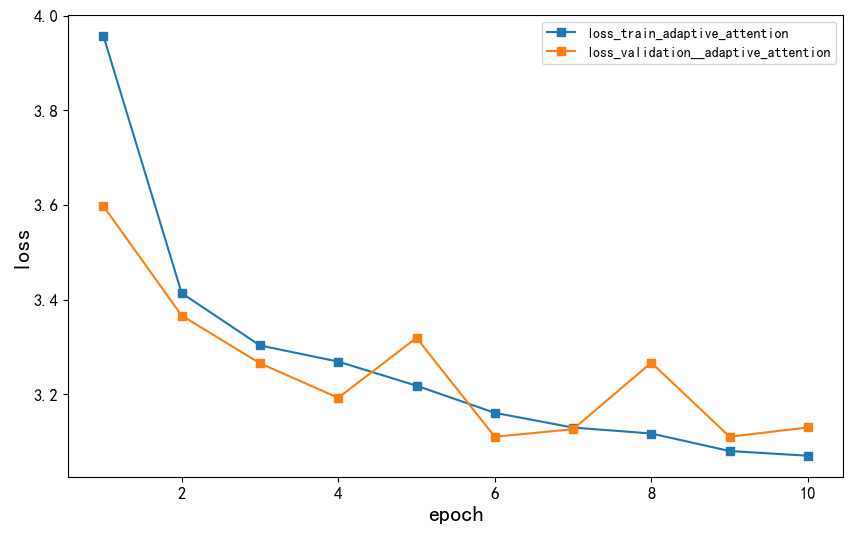

In [1]:

import matplotlib.pyplot as plt

#ResNet152 数据来源：参见上面的运行结果
loss_train_adaptive_att = [3.9575, 3.4138, 3.3033, 3.2692, 3.2183, 3.1610, 3.1299, 3.1173, 3.0803, 3.0704 ]
loss_validation_adaptive_att = [3.5978, 3.3665, 3.2656, 3.1927, 3.3194, 3.1104, 3.1264, 3.2670, 3.1105, 3.1301 ]

plt.rcParams['font.sans-serif']=['SimHei']
fig, ax = plt.subplots(figsize=(10,6), dpi=100)
ax.plot(range(1,11), loss_train_adaptive_att, marker='s', label ='loss_train_adaptive_attention')
ax.plot(range(1,11), loss_validation_adaptive_att, marker='s', label ='loss_validation__adaptive_attention')
# ax.axvline(12,0,1, linestyle='--', c='g')
plt.xlabel('epoch', fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('loss', fontsize=16)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

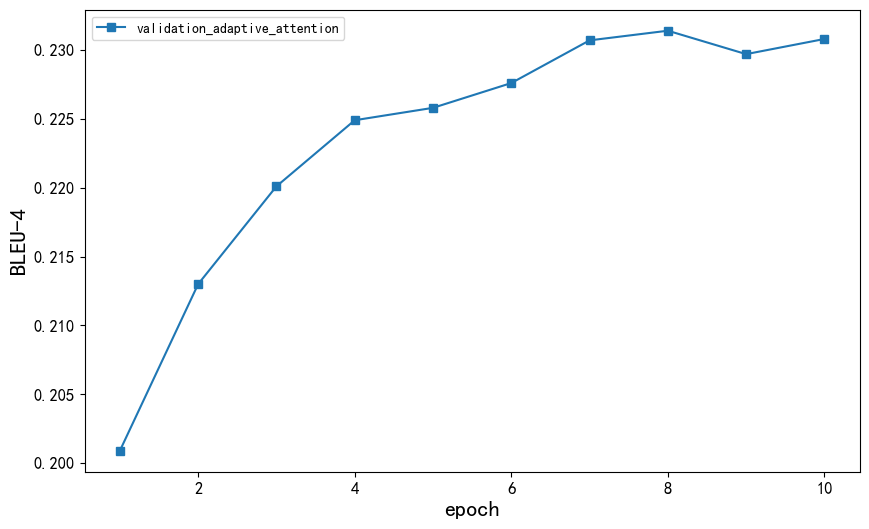

In [2]:
#数据来源：参见上面的运行结果
bleu4_validation_adaptive_att = [0.2009, 0.2130, 0.2201, 0.2249, 0.2258, 0.2276, 0.2307, 0.2314, 0.2297, 0.2308 ]

plt.rcParams['font.sans-serif']=['SimHei']
fig, ax = plt.subplots(figsize=(10,6), dpi=100)
ax.plot(range(1,11), bleu4_validation_adaptive_att, marker='s', label ='validation_adaptive_attention')
# ax.axvline(12,0,1, linestyle='--', c='g')
plt.xlabel('epoch', fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('BLEU-4', fontsize=16)
plt.yticks(fontsize=12)
plt.legend()
plt.show()